In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [26]:
batchSize = 4
def collate_fn(data):
    '''
       data: some audios
       we randomly split audio into frames 1, 2, 3, 4, 5 seconds
    '''
    batch_range = len(data[0])//44100//batchSize
    #44.1KHz :
    choosenRange = np.random.choice([1, 2, 3, 4, 5])
    d_stack = []
    for i in range(batchSize):
        randomStart = int(np.random.uniform(batch_range*i, batch_range*(i+1)-choosenRange))
        d_stack.append(data[:, randomStart*44100:randomStart*44100+choosenRange*44100])
    output = torch.stack(d_stack)
    return output


class PianoSet(Dataset):
    def __init__(self, path_to_data, cycle=2) -> None:
        self.path = path_to_data
        self.data = next(os.walk(path_to_data), (None, None, []))[2]
        self.cycle = cycle
    
    def __len__(self):
        return len(self.data) * self.cycle

    def __getitem__(self, idx):
        if idx >= len(self.data):
            #cycle back
            idx = idx-len(self.data)
        audio, _ = torchaudio.load(os.path.join(self.path, self.data[idx]))
        #downmix to single channel
        audio = torch.mean(audio, dim=0, keepdim=True)
        return audio



dataset = PianoSet(path_to_data="/Users/roywang/Schools/Project/archive")
data = DataLoader(dataset, batch_size=None, batch_sampler=None, shuffle=True, collate_fn=collate_fn)
for audio in data:
    print(audio.shape)

18
torch.Size([4, 1, 88200])
28
torch.Size([4, 1, 44100])
19
torch.Size([4, 1, 220500])
31
torch.Size([4, 1, 88200])
26
torch.Size([4, 1, 88200])
28
torch.Size([4, 1, 176400])
19
torch.Size([4, 1, 220500])
22
torch.Size([4, 1, 88200])
32
torch.Size([4, 1, 88200])
18
torch.Size([4, 1, 176400])
15
torch.Size([4, 1, 132300])
19
torch.Size([4, 1, 88200])
19
torch.Size([4, 1, 132300])
14
torch.Size([4, 1, 132300])
17
torch.Size([4, 1, 176400])
18
torch.Size([4, 1, 176400])
38
torch.Size([4, 1, 88200])
15
torch.Size([4, 1, 132300])
15
torch.Size([4, 1, 132300])
15
torch.Size([4, 1, 176400])
18
torch.Size([4, 1, 220500])
12
torch.Size([4, 1, 176400])
12
torch.Size([4, 1, 220500])
32
torch.Size([4, 1, 220500])
38
torch.Size([4, 1, 44100])
17
torch.Size([4, 1, 44100])
14
torch.Size([4, 1, 132300])
31
torch.Size([4, 1, 176400])
22
torch.Size([4, 1, 88200])
26
torch.Size([4, 1, 176400])


In [27]:
class forwardDiff:
    def __init__(self, beta_min, beta_max, diffusion_step=1000, device='cpu') -> None:
        self.diffusion_step = diffusion_step
        self.beta, self.alpha, self.alpha_hat = self.noise_schedule(beta_min, beta_max)

        self.beta = self.beta.to(device)
        self.alpha = self.alpha.to(device)
        self.alpha_hat = self.alpha_hat.to(device)


    def noise_schedule(self, beta_min, beta_max):
        beta = torch.linspace(beta_min, beta_max, self.diffusion_step, dtype=torch.float)
        alpha = 1 - beta
        alpha_hat = torch.cumprod(alpha, dim=0)
        return beta, alpha, alpha_hat

    #audio = [batch x channel x feature]
    def noise_audio(self, audio, time):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[time])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[time])[:, None, None]
        e = torch.rand_like(audio)
        return sqrt_alpha_hat * audio + sqrt_one_minus_alpha_hat * e, e
    
    def sample_timesteps(self, n):
        return torch.randint(low=1 ,high=self.diffusion_step, size=n)
    
    

22


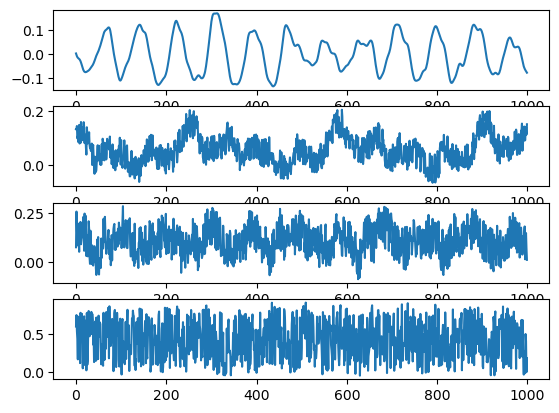

28


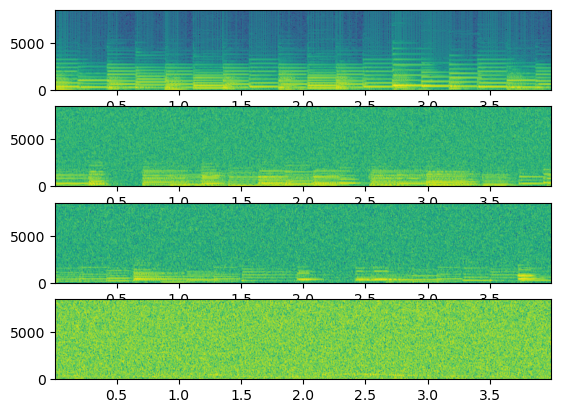

In [28]:
from matplotlib import pyplot as plt
from scipy import signal as sl
dif = forwardDiff(1e-7, 0.01)
def visualize_noising(audio, timeSteps:list):
    fig, ax = plt.subplots(len(timeSteps))
    noises, _ = dif.noise_audio(audio, timeSteps)
    for i, n in enumerate(noises):
        ax[i].plot(torch.arange(1000), n[0, :1000])
    plt.show()

def visualize_noise_as_mel(audio, timeSteps:list):
    fig, ax = plt.subplots(len(timeSteps))
    noises, _ = dif.noise_audio(audio, timeSteps)
    for i, n in enumerate(noises):
        f, t, Sxx = sl.spectrogram(n, 44100, window='hamming',nperseg=512, noverlap=256, scaling='density')
        ax[i].pcolormesh(t, f[:100], 20*np.log10(Sxx[0, :100, :]), shading='gouraud')
    plt.show()
    
tm_stp = [0, 50, 100, 500]
visualize_noising(next(iter(data)), tm_stp)
visualize_noise_as_mel(next(iter(data)), tm_stp)